In [2]:
from concurrent.futures import ThreadPoolExecutor

import geopandas as gpd
import numpy as np
import odc.geo  # noqa: F401
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier

from utils import predict_xr

In [3]:
%reload_ext autoreload
%autoreload 2

## Find and load S2 data

Load data and set up your array to use for prediction

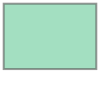

In [4]:
fiji_bbox = [177.2, -18.4, 178.9, -17.2]
fiji_bbox_geometry = geometry.box(*fiji_bbox)
fiji_bbox_geometry

In [5]:
collection = "dep_s2_geomad"

client = Client.open("https://stac.staging.digitalearthpacific.org")

items = list(client.search(
    collections=[collection],
    bbox=fiji_bbox,
    datetime="2023"
).items())

print(f"Found {len(items)} items")

Found 6 items


In [6]:
# S2 bands https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a

bands = [
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B11",
    "B12",
    "emad",
    "bcmad",
    "smad",
]

data = load(
    items,
    bbox=fiji_bbox,
    measurements=bands,
    resolution=10,
    chunks={"x": 2000, "y": 2000, "time": 1},
)

data = data.squeeze("time")

data

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
    time         datetime64[ns] 2023-01-01
Data variables: (12/13)
    B02          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ...           ...
    B8A          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B11          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B12          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    emad         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    smad         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>

In [7]:
# Add in the DEM here - https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30

# Get MPC dependencies

from planetary_computer import sign_url
import os

# Get the URL for STAC API on MSPC
catalogue_dem = "https://planetarycomputer.microsoft.com/api/stac/v1/"

collection_dem = "cop-dem-glo-30"

client_dem = Client.open(catalogue_dem)

# Search for datasets

fiji_bbox = [177.2, -18.4, 178.9, -17.2]

# datetime not necessary for DEM? 
# datetime = "2023"

# Get a pystac client for the MSPC
items_dem = list(client_dem.search(collections=[collection_dem], bbox=fiji_bbox).items())
print(len(items_dem))

4


In [8]:
# Authorised access to MPC data
os.environ["PC_SDK_SUBSCRIPTION_KEY"] = "84162f5502174b1b838239e74a44898d"

In [9]:
# Load dem data - 

data_dem = load(items_dem, chunks={}, groupby="solar_day", like=data, patch_url=sign_url)

data_dem = data_dem.where(data_dem != -32768)

data_dem

<xarray.Dataset>
Dimensions:      (time: 1, y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2021-04-22
Data variables:
    data         (time, y, x) float32 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>

In [10]:
# Merge DEM with S2 data
merged = data.update(data_dem)
merged

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925, time: 1)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2021-04-22
Data variables: (12/14)
    B02          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B06          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B07          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    ...           ...
    B11          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    B12          (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    emad         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    bcmad        (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    smad         (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    data         (time, y, x) float32 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>

### ==Check that this has worked with Alex==

#### <code style="background:yellow;color:black">Check that DEM data has been correctly downloaded and integrated.</code> 

Table 1. Sentinel 2 bands and respective wavelengths
<div><img src="Spectral_Indices.JPG" width="600"/>

In [11]:
# Add more indices here...

# Incorporate NDVI (Normalised Difference Vegetation Index) = (NIR-red)/(NIR+red)
data["ndvi"] = (data["B08"] - data["B04"]) / (data["B08"] + data["B04"])

# Incorporate MNDWI (Mean Normalised Difference Water Index) = (Green – SWIR) / (Green + SWIR)
data["mndwi"] = (data["B03"] - data["B12"]) / (data["B03"] + data["B12"])

# Incorporate EVI (Enhanced Vegetation Index) = 2.5NIR−RED(NIR+6RED−7.5BLUE)+1
data["evi"] = (2.5*(data["B08"] - data["B04"]))*((data["B08"] + (6*(data["B04"]) - (7.5*(data["B02"])))))+1

# Incorporate SAVI (Standard Vegetation Index) = (800nm−670nm) / (800nm+670nm+L(1+L)) # where L = 0.5
data["savi"] = (data["B07"] - data["B04"]) / (data["B07"] + data["B04"] + 0.5*(1 + 0.5))

# Incorporate BSI (Bare Soil Index) = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2)) # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/barren_soil/
data["bsi"] = ((data["B11"] + data["B04"]) - (data["B08"] + data["B02"])) / ((data["B11"] + data["B04"]) + (data["B08"] + data["B02"])) 

# Incorporate NDMI (Normalised Difference Moisture Index) # https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndmi/
data["ndmi"] = ((data["B08"]) - (data["B11"])) / ((data["B08"]) + (data["B11"]))

# Incorporate NDBI (Normalised Difference Built-up Index) (B06 - B05) / (B06 + B05); # - built up ratio of vegetation to paved surface - let BU = (ndvi - ndbi) - https://custom-scripts.sentinel-hub.com/custom-scripts/landsat-8/built_up_index/
data["ndbi"] = ((data["B06"]) - (data["B05"])) / ((data["B06"]) + (data["B05"]))


# Quartz requires ASTER  # https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/aster-overview/#:~:text=The%20Advanced%20Spaceborne%20Thermal%20Emission,launched%20on%20December%2018%2C%201999.


merged = data.compute()
merged

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925, time: 1)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2021-04-22
Data variables: (12/21)
    B02          (y, x) float32 1.45e+03 1.459e+03 ... 1.421e+03 1.422e+03
    B03          (y, x) float32 1.277e+03 1.287e+03 ... 1.255e+03 1.248e+03
    B04          (y, x) float32 1.185e+03 1.201e+03 ... 1.192e+03 1.191e+03
    B05          (y, x) float32 1.189e+03 1.202e+03 ... 1.197e+03 1.201e+03
    B06          (y, x) float32 1.171e+03 1.185e+03 ... 1.176e+03 1.18e+03
    B07          (y, x) float32 1.178e+03 1.194e+03 ... 1.178e+03 1.182e+03
    ...           ...
    mndwi        (y, x) float32 0.05016 0.04976 0.04976 ... 0.03462 0.03098
    evi          (y, x) float32 2.222e+05 2.576e+05 ... 9.318e+04 1.174e+05
    savi         (y, x) float32 -0.002961 -0.002922 ... -0.005905 -0.003791
    bsi          (y, x) float32 -0.05155 -0.04905 -0.04905 ... -0.04528 -0.04472
    ndmi         (y, x) float32 -0.004325 -0.005567 ... -0.001698 -0.003828
    ndbi         (y, x) float32 -0.007627 -0.007122 ... -0.00885 -0.00882

## Find and load S1 data

Load data and set up your array to use for prediction

In [11]:
# Get S-1 dependencies

from planetary_computer import sign_url
import os

In [12]:
# Get the URL for STAC API on MSPC
catalogue_s1 = "https://planetarycomputer.microsoft.com/api/stac/v1/"

collection_s1 = "sentinel-1-rtc"

client_s1 = Client.open(catalogue_s1)

# STAC ITEM Geomedian S1 - https://stac-browser.staging.digitalearthpacific.org/?.language=en


In [14]:
# Search for datasets

fiji_bbox = [177.2, -18.4, 178.9, -17.2]

datetime = "2023"


In [14]:
# Get a pystac client for the MSPC
items_s1 = list(client_s1.search(collections=[collection_s1], bbox=fiji_bbox, datetime=datetime).items())
print(len(items_s1))

133


In [15]:
# Authorised access to MPC data
os.environ["PC_SDK_SUBSCRIPTION_KEY"] = "84162f5502174b1b838239e74a44898d"

In [16]:
# Load data

data_s1 = load(items_s1, chunks={}, groupby="solar_day", like=data, patch_url=sign_url)

data_s1 = data_s1.where(data_s1 != -32768)

data_s1

<xarray.Dataset>
Dimensions:      (time: 107, y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01T06:40:42.198354 ... 2023-12...
Data variables:
    vh           (time, y, x) float32 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    vv           (time, y, x) float32 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>

In [17]:
# Create means over time and S1 bands
mean_s1 = data_s1.mean(dim="time")
mean_s1["vv_vh"] = mean_s1.vv/mean_s1.vh
mean_s1

<xarray.Dataset>
Dimensions:      (y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
Data variables:
    vh           (y, x) float32 dask.array<chunksize=(13946, 18925), meta=np.ndarray>
    vv           (y, x) float32 dask.array<chunksize=(13946, 18925), meta=np.ndarray>
    vv_vh        (y, x) float32 dask.array<chunksize=(13946, 18925), meta=np.ndarray>

## Find and load ASTER data (may only be useful for Landsat products and historic analyses from 2001-2006)

Load data and set up your array to use for prediction

In [17]:
# Get the URL for STAC API on MSPC
catalogue_aster = "https://planetarycomputer.microsoft.com/api/stac/v1/"

collection_aster = "aster-l1t"

client_aster = Client.open(catalogue_aster)

datetime_aster = "2006"

In [18]:
items_aster = list(client_aster.search(collections=[collection_aster], bbox=fiji_bbox, datetime=datetime_aster).items())
print(len(items_aster))

9


In [20]:
data_aster = load(items_aster, chunks={}, groupby="solar_day", like=data, patch_url=sign_url)

data_aster = data_aster.where(data_aster != -32768)


# Quartz requires ASTER  # https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/aster-overview/#:~:text=The%20Advanced%20Spaceborne%20Thermal%20Emission,launched%20on%20December%2018%2C%201999.
data_aster["QI"] = (data_aster["TIR_Band14"]) / (data_aster["TIR_Band12"]) 


In [21]:
data_aster

<xarray.Dataset>
Dimensions:      (time: 3, y: 13946, x: 18925)
Coordinates:
  * y            (y) float64 -1.931e+06 -1.932e+06 ... -2.071e+06 -2.071e+06
  * x            (x) float64 3.028e+06 3.028e+06 ... 3.217e+06 3.217e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2006-02-25T22:29:14.153000 ... 2006-05...
Data variables: (12/15)
    TIR_Band10   (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    TIR_Band11   (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    TIR_Band12   (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    TIR_Band13   (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    TIR_Band14   (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    SWIR_Band4   (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    ...           ...
    SWIR_Band8   (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    SWIR_Band9   (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    VNIR_Band1   (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    VNIR_Band2   (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    VNIR_Band3N  (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>
    QI           (time, y, x) float64 dask.array<chunksize=(1, 13946, 18925), meta=np.ndarray>

## Merge together all data into an array

Merge all collated data and set up your array to use for prediction

In [18]:
merged = data.update(mean_s1).compute()

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [ ]:
merged

## Train and predict

When you change your training data, you can re-train and predict here.

In [19]:
training_file = "training_data/draft_inputs/MRD_joined_14.geojson"

tdata = gpd.read_file(training_file, bbox=fiji_bbox_geometry)
tdata.explore()

In [21]:
from tqdm import tqdm

projected_training_data = tdata.to_crs("EPSG:3832")

# Remove the ID field
# projected_training_data.drop(columns=["id"], inplace=True)

training_array = []


def get_training_data(id_row):
    _, row = id_row
    cls_id = row["lulc_code"]
    # id = row["id"]
    geom = row["geometry"]

    # Get xarray values at the point
    x = merged.sel(x=geom.x, y=geom.y, method="nearest")
    one_point = [cls_id] + [float(v) for v in x.values()]
    return one_point


with ThreadPoolExecutor(max_workers=10) as executor:
    training_array = list(
        tqdm(
            executor.map(get_training_data, projected_training_data.iterrows()),
            total=len(projected_training_data),
        )
    )

print(f"Fetched data for {len(training_array)} training points")

100%|██████████| 839/839 [00:00<00:00, 489364.63it/s]

Fetched data for 839 training points


In [22]:
classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=42,
)

training_data = np.array(training_array)[:, 1:]
classes = np.array(training_array)[:, 0]

model = classifier.fit(training_data, classes)

In [23]:
classifier.feature_importances_

array([0.05740089, 0.02441587, 0.05016796, 0.03748218, 0.03018466,
       0.03183553, 0.06057251, 0.03353571, 0.05358017, 0.09128109,
       0.01805693, 0.01936343, 0.02059912, 0.10888036, 0.056386  ,
       0.02770812, 0.06151769, 0.02478714, 0.05661962, 0.05670822,
       0.03152113, 0.0080147 , 0.01120414, 0.02817684])

In [24]:
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3832")

ll = [-17.68786, 178.46045]
ur = [-17.60134, 178.55120]

ll_projected = transformer.transform(*ll)
ur_projected = transformer.transform(*ur)

predict_subset = merged.sel(
    x=slice(ll_projected[0], ur_projected[0]), y=slice(ur_projected[1], ll_projected[1])
)
# This one loads all the data from all Viti Levu
predict_subset = predict_subset.fillna(-9999)
predict_subset

<xarray.Dataset>
Dimensions:      (y: 1005, x: 1011, time: 1)
Coordinates:
  * y            (y) float64 -1.978e+06 -1.978e+06 ... -1.988e+06 -1.988e+06
  * x            (x) float64 3.168e+06 3.168e+06 ... 3.178e+06 3.178e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2021-04-22
Data variables: (12/24)
    B02          (y, x) float32 1.352e+03 1.354e+03 ... 1.399e+03 1.408e+03
    B03          (y, x) float32 1.602e+03 1.618e+03 ... 1.764e+03 1.774e+03
    B04          (y, x) float32 1.301e+03 1.303e+03 ... 1.328e+03 1.337e+03
    B05          (y, x) float32 2.038e+03 2.04e+03 ... 2.274e+03 2.274e+03
    B06          (y, x) float32 4.249e+03 4.254e+03 ... 4.874e+03 4.88e+03
    B07          (y, x) float32 4.936e+03 4.944e+03 ... 5.69e+03 5.706e+03
    ...           ...
    bsi          (y, x) float32 -0.1889 -0.1831 -0.1969 ... -0.2172 -0.2057
    ndmi         (y, x) float32 0.2468 0.2396 0.2567 ... 0.3064 0.2778 0.2642
    ndbi         (y, x) float32 0.3517 0.3518 0.3485 ... 0.3753 0.3637 0.3643
    vh           (y, x) float32 0.05835 0.05583 0.05889 ... 0.06567 0.07229
    vv           (y, x) float32 0.2551 0.2074 0.2365 ... 0.2986 0.307 0.3463
    vv_vh        (y, x) float32 4.372 3.714 4.015 4.238 ... 4.956 4.675 4.791

In [25]:
# This runs the actual prediction
predicted = predict_xr(model, predict_subset, proba=True)

# Convert to int
cleaned_predictions = predicted.copy(deep=True)
cleaned_predictions.predictions.data = predicted.predictions.data.astype(np.int8)
cleaned_predictions.probabilities.data = predicted.probabilities.data.astype(np.float32)

cleaned_predictions = cleaned_predictions.rename({"predictions": "lulc", "probabilities": "prob"})

predicting...
   probabilities...


In [26]:
cleaned_predictions

<xarray.Dataset>
Dimensions:      (x: 1011, y: 1005)
Coordinates:
  * x            (x) float64 3.168e+06 3.168e+06 ... 3.178e+06 3.178e+06
  * y            (y) float64 -1.978e+06 -1.978e+06 ... -1.988e+06 -1.988e+06
    spatial_ref  int32 3832
Data variables:
    lulc         (y, x) int8 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2 2
    prob         (y, x) float32 92.21 65.43 91.07 94.18 ... 81.16 85.04 86.36
Attributes:
    grid_mapping:  spatial_ref

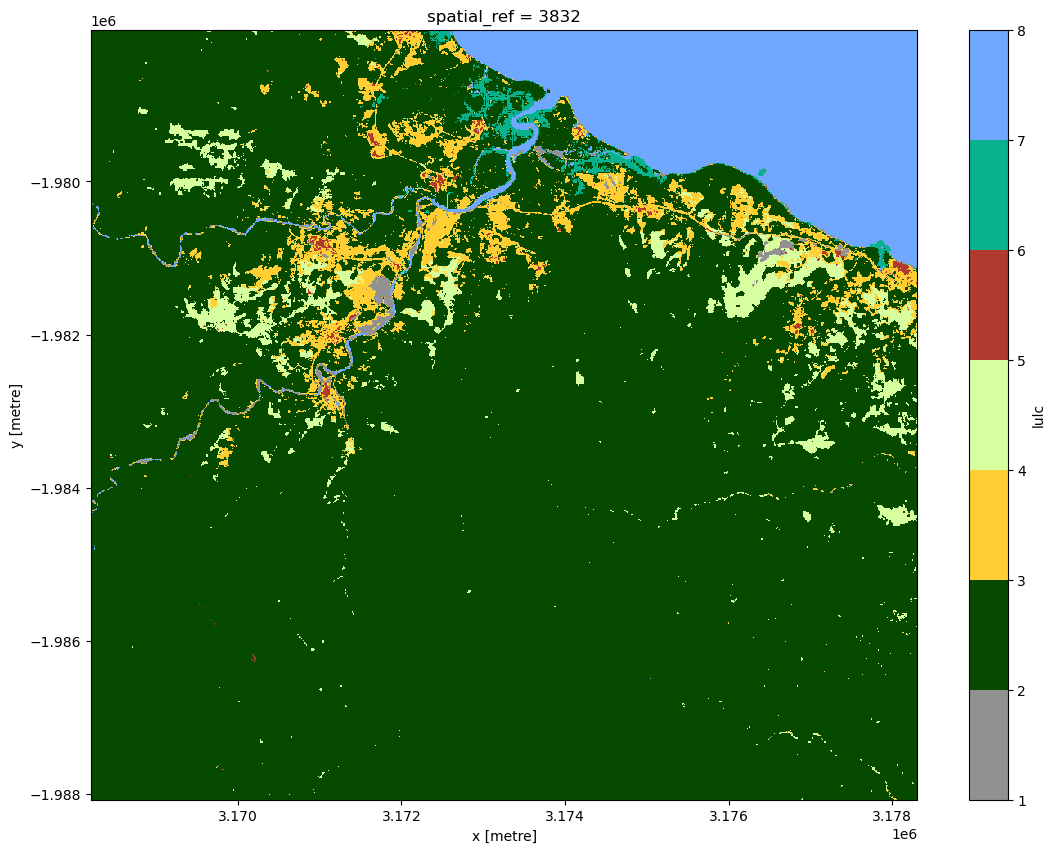

In [27]:
from matplotlib import colors

classes = [
    [1, "bare_land", "#919191"],
    [2, "forest", "#064a00"],
    [3, "crops", "#ffce33"],
    [4, "grassland", "#d7ffa0"],
    [5, "settlements", "#b03a2e"],
    [6, "mangroves", "#07b28d"],
    [7, "water", "#71a8ff"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [8]
norm = colors.BoundaryNorm(bounds, c_map.N)

cleaned_predictions.lulc.plot.imshow(cmap=c_map, norm=norm, size=10)

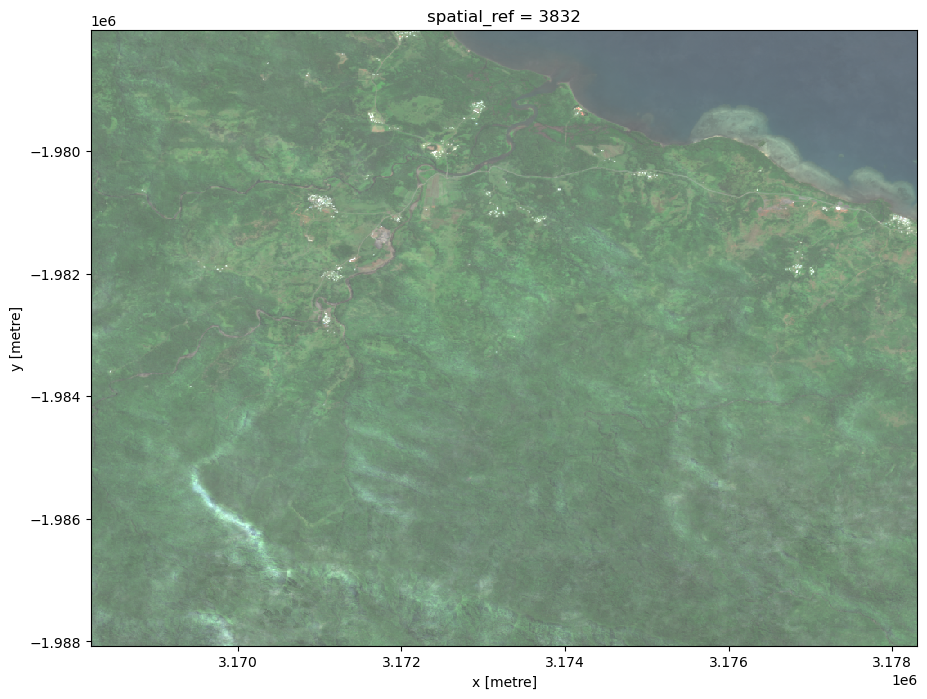

In [28]:
predict_subset[["B04", "B03", "B02"]].to_array().plot.imshow(size=8, vmin=0, vmax=3000)

In [22]:
# Write GeoTIFF
cleaned_predictions.lulc.odc.write_cog("lulc_fiji.tif", overwrite=True)

PosixPath('lulc_fiji.tif')